# Representing bags in <tt><b>torchmil</b></tt>

In the following, we explain how <tt><b>torchmil</b></tt> represents bags and how to use them in your code. 

This notebook contains:

- A brief introduction to bags in Multiple Instance Learning (MIL). 
- How to represent bags in <tt><b>torchmil</b></tt>.
- A first look at the `ToyDataset` from the [<tt><b>torchmil.datasets</b></tt>](../api/datasets/index.md) module.
- How mini-batching is handled in <tt><b>torchmil</b></tt>.
- Differences between the _sequential_ and _spatial_ representations of bags.

## What is a bag?

In Multiple Instance Learning (MIL), a bag is a collection of instances. Usually, both instances and bags have labels. However, it is assumed that the labels of the instances in a bag are not available at training time. Instead, we only have access to:

- The label of the bag, 
- Some kind of relation between the instance labels and the bag label.

Additionally, a bag can have some structure, such as a graph representing the relationships between the instances in the bag, or the coordinates of the instances in some space.
All these cases can be handled with <tt><b>torchmil</b></tt>.

!!! example "Example: MIL binary classification"
    In this case, the bags have the form $\mathbf{X} = \left[ \mathbf{x}_1, \ldots, \mathbf{x}_N \right]^\top \in \mathbb{R}^{N \times D}$, where each $\mathbf{x}_n \in \mathbb{R}^D$ is an instance. 
    The labels of the instances are $\mathbf{y} = \left[ y_1, \ldots, y_N \right]^\top \in \{0, 1\}^N$, but we do not have access to them at training time (they may be accessible at test time). The label of the bag is $Y \in \{0, 1\}$, and the relation between the instance labels and the bag label is as follows:

    $$ Y = \max \left\{ y_1, \ldots, y_N \right\} $$

    This example is the most common in MIL, but there are many other possibilities. 

## How bags are represented in torchmil?

In <tt><b>torchmil</b></tt>, bags are represented as a `TensorDict` object, which stores any kind of information about the bag. In most cases, a bag will contain at least the following _properties_:

- `bag['X']`: a tensor of shape `(bag_size, ...)` containing the instances in the bag. Usually, this tensor is called _bag feature matrix_, since these instances are feature vectors extracted from the raw representation of the instances. Therefore, in most cases it has shape `(bag_size, feature_dim)`. 
- `bag['Y']`: a tensor containing the label of the bag. In the simplest case, this tensor is a scalar, but it can be a tensor of any shape (e.g., in multi-class MIL).

Additionally, a bag may contain other _properties_. The most common ones in <tt><b>torchmil</b></tt> are:

- `bag['y_inst']`: a tensor of shape `(bag_size, ...)` containing the labels of the instances in the bag. In the pure MIL setting, this tensor is only used for evaluation purposes since the label of the instances are not known. However, some methods may require some sort of supervision at the instance level.
- `bag['adj']`: a tensor of shape `(bag_size, bag_size)` containing the adjacency matrix of the bag. This matrix is used to represent the relationships between the instances in the bag. The methods implemented in [<tt><b>torchmil.models</b></tt>](../api/models/index.md) allow this matrix to be a sparse tensor.
- `bag['coords']`: a tensor of shape `(bag_size, coords_dim)` containing the coordinates of the instances in the bag. This tensor is used to represent the absolute position of the instances in the bag.

## Example: MNIST

Creating a bag is as simple as creating a `TensorDict` object.
Let's use the MNIST dataset to illustrate how bags are represented in <tt><b>torchmil</b></tt>.

In [1]:
import torch
from torchvision import datasets, transforms

# Load MNIST dataset
mnist = datasets.MNIST(
    "/tmp/", train=True, download=True, transform=transforms.ToTensor()
)

# Extract features and labels
data = mnist.data.view(-1, 28 * 28) / 255
labels = mnist.targets

Let's create a bag of 10 instances. The label of each instance will be the digit it represents, and the label of the bag will be the maximum digit in the bag.

In [2]:
from tensordict import TensorDict

# Select 10 random indices
indices = torch.randperm(data.size(0))[:10]

bag = TensorDict(
    {"X": data[indices], "y_inst": labels[indices], "Y": labels[indices].max()}
)
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([10, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Now, let's create a MIL dataset using the `ToyDataset` class from [<tt><b>torchmil.datasets</b></tt>](../api/datasets/index.md).

We will create a binary dataset, where the digits $4$ and $5$ are the positive instances (their label is $1$), and the rest are the negative instances (their label is $0$). Thus, the label of the bag is $1$ if it contains at least one $4$ or $5$, and $0$ otherwise.

In [3]:
from torchmil.datasets import ToyDataset

# Define positive labels
obj_labels = [4, 5]  # Digits 4 and 5 are considered positive

# Create MIL dataset
toy_dataset = ToyDataset(data, labels, num_bags=100, obj_labels=obj_labels, bag_size=10)

# Retrieve a bag
bag = toy_dataset[0]
bag

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([10, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Let's visualize the bags

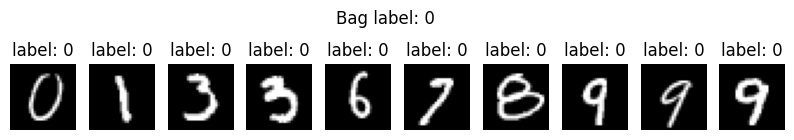

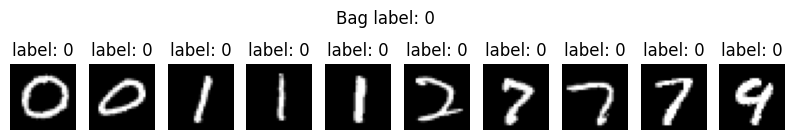

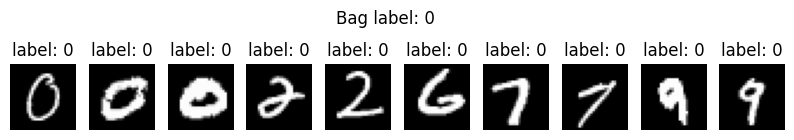

In [4]:
import matplotlib.pyplot as plt


def plot_bag(bag):
    bag_size = len(bag["X"])
    fig, axes = plt.subplots(1, bag_size, figsize=(bag_size, 1.8))
    for i in range(bag_size):
        ax = axes[i]
        ax.imshow(bag["X"][i].view(28, 28), cmap="gray")
        ax.set_title(f"label: {bag['y_inst'][i].item()}")
        ax.axis("off")
    fig.suptitle(f'Bag label: {bag["Y"].item()}')
    plt.show()


for i in range(3):
    bag = toy_dataset[i]
    plot_bag(bag)

## Mini-batches in <tt><b>torchmil</b></tt>: masks

Mini-batches enable the training of deep learning models with huge amounts of data. In <tt><b>torchmil</b></tt>, mini-batches are handled by the `collate_fn` function of [<tt><b>torchmil.data</b></tt>](../api/data/index.md), which is used to collate a list of bags into a batch.

In MIL, each bag can be of different size. To solve this, in <tt><b>torchmil</b></tt>, the tensors in the bags are padded to the maximum size of the bags in the batch. A mask tensor is used to indicate which elements of the padded tensors are real instances and which are padding. This mask tensor is used to adjust the behavior of the models to ignore the padding elements (e.g., in the attention mechanism).

!!! question "Why not use [`torch.nested`](https://pytorch.org/docs/stable/nested.html)?"
    `torch.nested` offer a more flexible method for handling bags of varying sizes. However, since the PyTorch API for nested tensors is still in the prototype stage, <tt><b>torchmil</b></tt> currently relies on the padding approach.

We illustrate this behaviour in the following example. We use again the MNIST dataset, but this time we create a dataset with bags of different sizes.

In [5]:
from torchmil.datasets import ToyDataset

# Define positive labels
obj_labels = [4, 5]  # Digits 4 and 5 are considered positive

# Create MIL dataset
toy_dataset = ToyDataset(
    data, labels, num_bags=100, obj_labels=obj_labels, bag_size=(4, 10)
)

We retrieve four bags from the dataset and collate them into a batch. A batch is just a `TensorDict` object containing the padded tensors and the mask tensor.

In [6]:
from torchmil.data import collate_fn

bag_list = [toy_dataset[i] for i in range(4)]
batch = collate_fn(bag_list)
batch

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([4, 9, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([4]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([4, 9]), device=cpu, dtype=torch.uint8, is_shared=False),
        y_inst: Tensor(shape=torch.Size([4, 9]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

Let's plot the bags in the batch and the mask tensor.

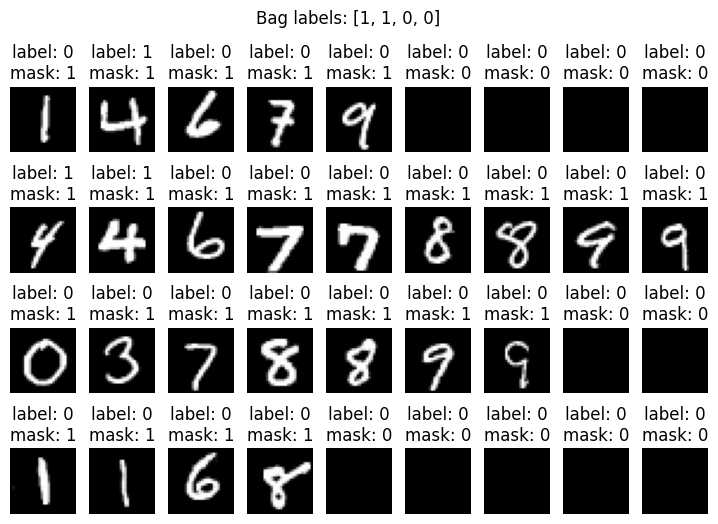

In [7]:
def plot_batch(batch):
    batch_size = len(batch["X"])
    bag_size = len(batch["X"][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5 * batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch["X"][i][j].view(28, 28), cmap="gray")
            ax.set_title(
                f"label: {batch['y_inst'][i][j].item()}\nmask: {batch['mask'][i][j].item()}"
            )
            ax.axis("off")
        fig.suptitle(f'Bag labels: {batch["Y"].tolist()}')


plot_batch(batch)

As we can see, the bags are padded to the maximum size of the bags in the batch with zeros. The mask tensor indicates which elements are real instances and which are padding. Additionally, the function `collate_fn` also pads other tensors, such as the adjacency matrix or the instance coordinates. 

## Sequential representation vs spatial representation

In <tt><b>torchmil</b></tt>, bags can be represented in two ways: sequential and spatial. 

In the sequential representation `bag['X']` is a tensor of shape `(bag_size, dim)`. This representation is the most common in MIL. 
When the bag has some spatial structure, the sequential representation can be coupled with a graph using an adjacency matrix or with the coordinates of the instances. These are stored as `bag['adj']` (of shape `(bag_size, bag_size)`) and `bag['coords']` (of shape `(bag_size, coords_dim)`), respectively.

Alternatively, the spatial representation can be used. In this case, `bag['X']` is a tensor of shape `(coord1, ..., coordN, dim)`, where `N=coords_dim` is the number of dimensions of the space.

In <tt>torchmil</tt>, you can convert from one representation to the other using the functions `torchmil.utils.seq_to_spatial` and `torchmil.utils.spatial_to_seq` from the [<tt><b>torchmil.data</b></tt>](../api/data/index.md) module. These functions need the coordinates of the instances in the bag, stored as `bag['coords']`.

!!! example "Example: Whole Slide Images"
    Due to their large resolution, Whole Slide Images (WSIs) are usually represented as bags of patches. Each patch is an image, from which a feature vector of is typically extracted. The spatial representation of a WSI has shape `(height, width, feat_dim)`, while the sequential representation has shape `(bag_size, feat_dim)`. The coordinates corresponds to the coordinates of the patches in the WSI. 

    [SETMIL](../api/models/setmil.md) is an example of a model that uses the spatial representation of a WSI. 

Let's illustrate this with an example. Again, using MNIST, we will create a bag of 10 instances, and randomly place them in a canvas.

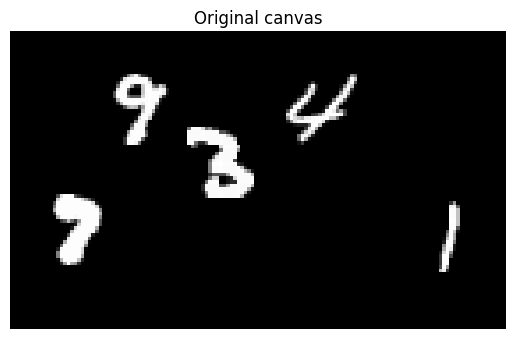

In [8]:
# Select 10 random indices
indices = torch.randperm(data.size(0))[:5]

bag = TensorDict(
    {"X": data[indices], "y_inst": labels[indices], "Y": labels[indices].max()}
)

# Create the canvas
height = 3 * 28
width = 5 * 28
canvas = torch.zeros(height, width)

# Randomly place the digits on the canvas
torch.manual_seed(5)  # set seed
coords_list = []
for n in range(5):
    i = torch.randint(0, height - 28, (1,)).item()
    j = torch.randint(0, width - 28, (1,)).item()
    canvas[i : i + 28, j : j + 28] = bag["X"][n].view(28, 28)
    coords_list.append((i, j))

# Convert to tensor
coords = torch.tensor(coords_list)

# Display the canvas
plt.imshow(canvas, cmap="gray")
plt.title("Original canvas")
plt.axis("off")
plt.show()

Now, the digits in our bag have a spatial structure given by their coordinates. Let's compute the spatial representation of the bag using the coordinates.

In [9]:
from torchmil.data import seq_to_spatial, spatial_to_seq

X = bag["X"].unsqueeze(0)  # add batch dimension for seq_to_spatial and spatial_to_seq
coords = coords.unsqueeze(
    0
)  # add batch dimension for seq_to_spatial and spatial_to_seq
X_esp = seq_to_spatial(X, coords)  # remove batch dimension
X_seq = spatial_to_seq(X_esp, coords)  # remove batch dimension

# Remove batch dimension
coords = coords.squeeze(0)
X = X.squeeze(0)
X_seq = X_seq.squeeze(0)
X_esp = X_esp.squeeze(0)

print("X shape:", X.shape)
print("X_seq shape:", X_seq.shape)
print("X_esp shape:", X_esp.shape)
print("X and X_seq are equal:", torch.allclose(X, X_seq))

X shape: torch.Size([5, 784])
X_seq shape: torch.Size([5, 784])
X_esp shape: torch.Size([44, 111, 784])
X and X_seq are equal: True


`X_esp` is the spatial representation of the bag. It is equivalent to the canvas with the digits placed in the corresponding coordinates. Let's reconstruct the canvas using it. 

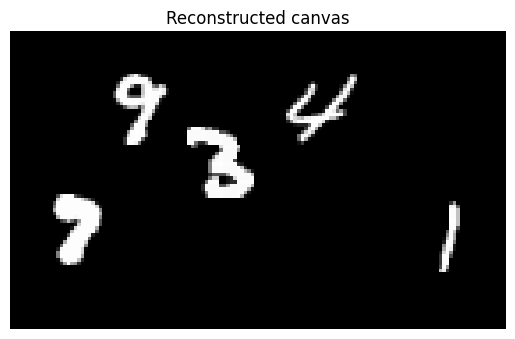

In [10]:
canvas_rec = torch.zeros(height, width)
for n in range(5):
    i, j = coords[n]
    canvas_rec[i : i + 28, j : j + 28] = X_esp[i, j, :].view(28, 28)

plt.imshow(canvas_rec, cmap="gray")
plt.title("Reconstructed canvas")
plt.axis("off")
plt.show()

Finally, the sequential representation, which is already stored in `bag`, can be coupled with the coordinates. Using these coordinates, we can compute an adjacency matrix. 

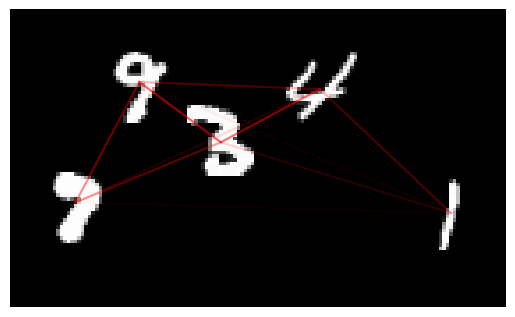

In [11]:
coords = coords.squeeze(0).type(torch.float32)  # convert to float32
bag["coords"] = coords  # add to bag

# Create the adjacency matrix. Each entry (i, j) is given by an RBF kernel evaluated at coordinates i and j with a length scale of 28
adj = torch.zeros(5, 5)
for i in range(5):
    for j in range(5):
        if i != j:
            adj[i, j] = torch.exp(-torch.norm(coords[i] - coords[j]) / 28)
bag["adj"] = adj  # add to bag

# Plot the canvas with the adjacency matrix overlayed
plt.imshow(canvas, cmap="gray")
for i in range(5):
    for j in range(5):
        plt.plot(
            [coords[i, 1] + 14, coords[j, 1] + 14],
            [coords[i, 0] + 14, coords[j, 0] + 14],
            "r",
            alpha=adj[i, j].item(),
        )
plt.axis("off")
plt.show()

The adjacency matrix indicates the distance between the digits in the bag. 